In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score,cross_validate, RandomizedSearchCV, train_test_split
import optuna
import xgboost as xgb
from sklearn.metrics import r2_score 
import joblib

In [2]:
df2 = pd.read_excel("../markaFile/Honda.xlsx",sheet_name="Sheet1")

In [3]:
df2.drop("Unnamed: 0",axis=1, inplace=True)

In [4]:
df2.head()

,Fiyat,Yıl,Motor Gücü,Motor Hacmi,Kilometre,Boya,Değişen,Seri_Accord,Seri_CRX,Seri_City,...,Model_2.2 EX,Model_2.2 VTi,Model_2.4 Executive,Model_3.5,Yakıt Tipi_Benzin,Yakıt Tipi_Dizel,Yakıt Tipi_LPG & Benzin,Vites Tipi_Düz,Vites Tipi_Otomatik,Vites Tipi_Yarı Otomatik
0,875000,2019,101,1401,70000,NaN,NaN,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,649500,2018,102,1318,38000,3.0,0.0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,985000,2020,125,1597,29500,0.0,0.0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,998000,2019,125,1597,36000,0.0,0.0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
4,795000,2017,125,1597,180000,NaN,NaN,0,0,0,...,0,0,0,0,0,0,1,0,1,0


In [5]:
y = df2["Fiyat"]
X = df2.drop(["Fiyat"], axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [7]:
def set_model(model_list, X_train, X_test, y_train, y_test):
    dataf = pd.DataFrame()

    for i in range(len(model_list)):
        algo_name = model_list[i][0]
        algo = model_list[i][1]

        model = algo.fit(X_train, y_train)

        cv_result = cross_val_score(model,
                                    X_train, y_train,
                                    cv=5,
                                    scoring="neg_mean_squared_error")

        y_pred = model.predict(X_test)
        rmse = np.mean(np.sqrt(-cv_result))
        data_list = {"Model": algo_name,
                     "TestDeger": rmse,
                     "MSE":mean_squared_error(y_test, y_pred),
                     "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
                     "MAE": mean_absolute_error(y_test, y_pred)}
        dataf = dataf.append(data_list, ignore_index=True)

    return dataf

In [8]:
models = []
#models.append(('Gradient Boosting Regressor', GradientBoostingRegressor()))
models.append(('XGBModel', XGBRegressor(objective="reg:squarederror",use_label_encoder=False)))
#models.append(('LGBMModel', LGBMRegressor(use_missing=False)))
#models.append(('LRModel', LinearRegression()))
#models.append(('RFModel', RandomForestRegressor()))

In [9]:
df2_model = set_model(models, X_train, X_test, y_train, y_test)
df2_model

C:\Users\senab\AppData\Local\Temp\ipykernel_15420\3059390516.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataf = dataf.append(data_list, ignore_index=True)


,Model,TestDeger,MSE,RMSE,MAE
0,XGBModel,62665.927597,4.796125e+09,69254.058541,46928.99595


In [10]:
def objective(n_trials):
  params = {
        'colsample_bytree': n_trials.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': n_trials.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        "learning_rate": n_trials.suggest_float("learning_rate", 1e-4, 0.5, log=True),
        'n_estimators': 10000,
        "max_depth": n_trials.suggest_int("max_depth", 3, 15),
        'min_child_weight': n_trials.suggest_int('min_child_weight', 1, 300),
    }
  dtrain = xgb.DMatrix(data = X_train, label = y_train)
  dval = xgb.DMatrix(data = X_test, label = y_test)

  regressor = xgb.train(params, dtrain) 
  y_pred = regressor.predict(dval)
  rmse = mean_squared_error(y_test, y_pred, squared=False)

  return rmse

In [11]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=250, n_jobs=-1)

[I 2023-10-08 14:12:20,486] A new study created in memory with name: no-name-fe8f0a85-0b56-429d-9da3-35139c7ec77a
[I 2023-10-08 14:12:20,674] Trial 1 finished with value: 672808.0286633515 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.0006017545655143755, 'max_depth': 15, 'min_child_weight': 204}. Best is trial 1 with value: 672808.0286633515.
[I 2023-10-08 14:12:20,716] Trial 2 finished with value: 660253.467380814 and parameters: {'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.0025712355194731896, 'max_depth': 11, 'min_child_weight': 240}. Best is trial 2 with value: 660253.467380814.
[I 2023-10-08 14:12:20,716] Trial 0 finished with value: 674859.7855345897 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.00024318618837508048, 'max_depth': 7, 'min_child_weight': 156}. Best is trial 2 with value: 660253.467380814.
[I 2023-10-08 14:12:20,769] Trial 5 finished with value: 634464.7633466076 and parameters: {'c

[I 2023-10-08 14:12:22,075] Trial 30 finished with value: 121011.21221837874 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.4756126953510304, 'max_depth': 3, 'min_child_weight': 268}. Best is trial 29 with value: 120842.02914219217.
[I 2023-10-08 14:12:22,106] Trial 31 finished with value: 120775.34129466179 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.4695312854657168, 'max_depth': 3, 'min_child_weight': 264}. Best is trial 31 with value: 120775.34129466179.
[I 2023-10-08 14:12:22,231] Trial 32 finished with value: 118395.10623778976 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.47930259003540004, 'max_depth': 8, 'min_child_weight': 256}. Best is trial 32 with value: 118395.10623778976.
[I 2023-10-08 14:12:22,309] Trial 34 finished with value: 117754.0426410135 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.49110379379958174, 'max_depth': 8, 'min_child_wei

[I 2023-10-08 14:12:24,042] Trial 60 finished with value: 114015.26146337234 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.34123919426694854, 'max_depth': 5, 'min_child_weight': 241}. Best is trial 59 with value: 105159.7903003512.
[I 2023-10-08 14:12:24,091] Trial 61 finished with value: 108313.84952927557 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.3358793856211739, 'max_depth': 5, 'min_child_weight': 130}. Best is trial 59 with value: 105159.7903003512.
[I 2023-10-08 14:12:24,106] Trial 62 finished with value: 106898.73889579136 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.39649008789961127, 'max_depth': 5, 'min_child_weight': 123}. Best is trial 59 with value: 105159.7903003512.
[I 2023-10-08 14:12:24,153] Trial 63 finished with value: 108393.72315098021 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.33337022501009694, 'max_depth': 5, 'min_child_weig

[I 2023-10-08 14:12:26,128] Trial 90 finished with value: 131799.63844373307 and parameters: {'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.19312515953046588, 'max_depth': 3, 'min_child_weight': 85}. Best is trial 84 with value: 96387.33869326086.
[I 2023-10-08 14:12:26,184] Trial 91 finished with value: 127592.60792794629 and parameters: {'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.20026953412513263, 'max_depth': 3, 'min_child_weight': 82}. Best is trial 84 with value: 96387.33869326086.
[I 2023-10-08 14:12:26,397] Trial 93 finished with value: 128930.29228408656 and parameters: {'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.19587550340464505, 'max_depth': 3, 'min_child_weight': 57}. Best is trial 84 with value: 96387.33869326086.
[I 2023-10-08 14:12:26,429] Trial 92 finished with value: 127066.79608530448 and parameters: {'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.19987042477215217, 'max_depth': 3, 'min_child_weight

[I 2023-10-08 14:12:28,509] Trial 120 finished with value: 94046.79111334616 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.26843118259155835, 'max_depth': 3, 'min_child_weight': 1}. Best is trial 106 with value: 81476.74214721016.
[I 2023-10-08 14:12:28,603] Trial 121 finished with value: 95214.0473504275 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.28223051481817224, 'max_depth': 14, 'min_child_weight': 4}. Best is trial 106 with value: 81476.74214721016.
[I 2023-10-08 14:12:28,618] Trial 122 finished with value: 98169.59926861436 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.28125660254134727, 'max_depth': 3, 'min_child_weight': 3}. Best is trial 106 with value: 81476.74214721016.
[I 2023-10-08 14:12:28,670] Trial 123 finished with value: 104553.035687789 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.2867847837166941, 'max_depth': 3, 'min_child_weight':

[I 2023-10-08 14:12:31,035] Trial 150 finished with value: 101749.26607331372 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.2866868267799554, 'max_depth': 12, 'min_child_weight': 17}. Best is trial 134 with value: 80199.73927343916.
[I 2023-10-08 14:12:31,238] Trial 151 finished with value: 158883.86290193917 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.16082238016696715, 'max_depth': 12, 'min_child_weight': 8}. Best is trial 134 with value: 80199.73927343916.
[I 2023-10-08 14:12:31,280] Trial 153 finished with value: 218041.74700426788 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.12300117915864878, 'max_depth': 13, 'min_child_weight': 46}. Best is trial 134 with value: 80199.73927343916.
[I 2023-10-08 14:12:31,348] Trial 154 finished with value: 113642.41837218238 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.22575970013824123, 'max_depth': 12, 'min_chi

[I 2023-10-08 14:12:33,942] Trial 178 finished with value: 95986.66781740641 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.49447544416617256, 'max_depth': 14, 'min_child_weight': 24}. Best is trial 134 with value: 80199.73927343916.
[I 2023-10-08 14:12:33,990] Trial 181 finished with value: 95585.63506704588 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.44123557145142855, 'max_depth': 13, 'min_child_weight': 24}. Best is trial 134 with value: 80199.73927343916.
[I 2023-10-08 14:12:34,102] Trial 183 finished with value: 96193.57661910997 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.4653152433868548, 'max_depth': 9, 'min_child_weight': 23}. Best is trial 134 with value: 80199.73927343916.
[I 2023-10-08 14:12:34,206] Trial 182 finished with value: 101026.16617334967 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.4324802669472553, 'max_depth': 3, 'min_child_we

[I 2023-10-08 14:12:37,373] Trial 209 finished with value: 473179.53761852795 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.03775615588228027, 'max_depth': 3, 'min_child_weight': 6}. Best is trial 206 with value: 79084.1583602903.
[I 2023-10-08 14:12:37,758] Trial 212 finished with value: 106498.72839231756 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.2577361461743701, 'max_depth': 3, 'min_child_weight': 7}. Best is trial 206 with value: 79084.1583602903.
[I 2023-10-08 14:12:37,758] Trial 213 finished with value: 105729.46990874643 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.26193019116216953, 'max_depth': 3, 'min_child_weight': 7}. Best is trial 206 with value: 79084.1583602903.
[I 2023-10-08 14:12:37,844] Trial 215 finished with value: 93165.82156748782 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.2586834499411332, 'max_depth': 3, 'min_child_weight':

[I 2023-10-08 14:12:40,309] Trial 239 finished with value: 78896.26118253011 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.39650514977891815, 'max_depth': 3, 'min_child_weight': 1}. Best is trial 239 with value: 78896.26118253011.
[I 2023-10-08 14:12:40,391] Trial 243 finished with value: 79253.4497532431 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.38923417095682555, 'max_depth': 3, 'min_child_weight': 1}. Best is trial 239 with value: 78896.26118253011.
[I 2023-10-08 14:12:40,427] Trial 241 finished with value: 79696.64618686854 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.3838996385098983, 'max_depth': 3, 'min_child_weight': 1}. Best is trial 239 with value: 78896.26118253011.
[I 2023-10-08 14:12:40,460] Trial 242 finished with value: 79436.01750966633 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.4069388345341908, 'max_depth': 3, 'min_child_weight': 

In [12]:
print(f"Optimized RMSE: {study.best_value:.4f}")
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Optimized RMSE: 78896.2612
Best params:
	colsample_bytree: 0.4
	subsample: 0.6
	learning_rate: 0.39650514977891815
	max_depth: 3
	min_child_weight: 1


In [13]:
model = XGBRegressor(objective="reg:squarederror",use_label_encoder=False)


final_model = model.set_params(**study.best_params).fit(X_train,y_train)
    
cv_results = cross_validate(final_model,
                            X_train, y_train,
                            cv=5,
                            scoring="neg_mean_squared_error")
    
y_pred = final_model.predict(X_test)

rmse = (np.sqrt(-cv_results['test_score'])).mean()
data_list = {"TestDeger": rmse,
             "MSE":mean_squared_error(y_test, y_pred),
             "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
             "MAE": mean_absolute_error(y_test, y_pred)}

print(data_list)

{'TestDeger': 59024.062097075664, 'MSE': 4034543741.7394376, 'RMSE': 63518.05839081857, 'MAE': 43603.81209384557}


In [14]:
r2 = r2_score(y_test, y_pred)
r2

0.9500782634779683

In [15]:
n= len(X_train)
p =len(X.columns)
adj_R2 = 1- ((1-r2) * (n-1)/(n-p-1))
adj_R2

0.9469407241714161

In [16]:
marka_model = joblib.dump(final_model, "Honda.pkl")

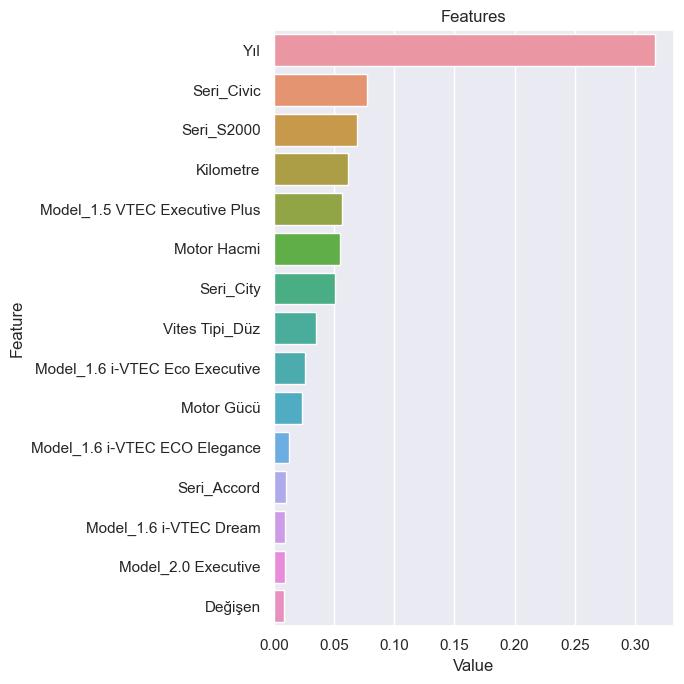

In [17]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(7, 7))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:15])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")
plot_importance(final_model,X)